Gemma 3 PT BR - Inference_images_and_videos

Por Bruno Henrique

https://www.linkedin.com/in/brunohenriquetech/


In [ ]:
!pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3

  Cloning https://github.com/huggingface/transformers (to revision v4.49.0-Gemma-3) to /tmp/pip-req-build-0vhf5_3d
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-0vhf5_3d
  Running command git checkout -q 1c0f782fe5f983727ff245c4c1b3906f9b99eec2
  Resolved https://github.com/huggingface/transformers to commit 1c0f782fe5f983727ff245c4c1b3906f9b99eec2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-py3-none-any.whl size=10936429 sha256=2e03cc450c7bc91fa2328992f99d8eaecc8a85a52f56af4a41042761c9430aaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-wupzmaro/wheels/53/15/d5/d63b866c641d8863f9cd29a4cc7a5efc38476c3aae8247c195
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transf

In [ ]:
from transformers import AutoProcessor, Gemma3ForConditionalGeneration
from PIL import Image
import cv2
from IPython.display import Markdown, HTML
from base64 import b64encode
import requests
import torch

Escolher o modelo

In [ ]:
model_name = 'gemma-3-4b-it' # @param ['gemma-3-1b-it', 'gemma-3-4b-it', 'gemma-3-12b-it', 'gemma-3-27b-it']
model_id = f"google/{model_name}"

model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id, device_map="auto", torch_dtype=torch.bfloat16,
).eval()

processor = AutoProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [18]:
def resize_image(image_path):
    img = Image.open(image_path)

    target_width, target_height = 640, 640
    # Calculate the target size (maximum width and height).
    if target_width and target_height:
        max_size = (target_width, target_height)
    elif target_width:
        max_size = (target_width, img.height)
    elif target_height:
        max_size = (img.width, target_height)

    img.thumbnail(max_size)

    return img


def get_model_response(img: Image, prompt: str, model, processor):
    # Prepare the messages for the model.
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "Você é um assistente útil. Responda apenas com a resposta à pergunta feita e evite usar texto adicional em sua resposta como 'aqui está a resposta.'."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": prompt}
            ]
        }
    ]

    # Tokenize inputs and prepare for the model.
    inputs = processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=True,
        return_dict=True, return_tensors="pt"
    ).to(model.device, dtype=torch.bfloat16)

    input_len = inputs["input_ids"].shape[-1]

    # Generate response from the model.
    with torch.inference_mode():
        generation = model.generate(**inputs, max_new_tokens=100, do_sample=False)
        generation = generation[0][input_len:]

    # Decode the response.
    response = processor.decode(generation, skip_special_tokens=True)
    return response


def extract_frames(video_path, num_frames):
    """
    The function is adapted from:
    https://github.com/merveenoyan/smol-vision/blob/main/Gemma_3_for_Video_Understanding.ipynb
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the step size to evenly distribute frames across the video.
    step = total_frames // num_frames
    frames = []

    for i in range(num_frames):
        frame_idx = i * step
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        timestamp = round(frame_idx / fps, 2)
        frames.append((img, timestamp))

    cap.release()
    return frames


def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  video_html = f"""<video width={video_width} controls><source src="{video_url}"></video>"""
  return HTML(video_html)

In [28]:
!wget https://huggingface.co/spaces/Bruno/gemma-3-12b-pt-br/resolve/main/assets/sample-images/pixnn.png -O /content/image_1.png
!wget https://raw.githubusercontent.com/NSTiwari/Inference-Gemma-3/main/assets/image_3.png -O /content/image_3.png


--2025-03-13 23:37:38--  https://huggingface.co/spaces/Bruno/gemma-3-12b-pt-br/resolve/main/assets/sample-images/pixnn.png
Resolving huggingface.co (huggingface.co)... 13.35.202.34, 13.35.202.97, 13.35.202.40, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.34|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/e1/8a/e18a73af6ba709fab5f923f86dbea0c5cc024a92a72a60e71c9c22830fbf3eb7/41813cf4fd32833eebfc585907bda2e22ce9bdb125687dca4b11506ca8b3ce86?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pixnn.png%3B+filename%3D%22pixnn.png%22%3B&response-content-type=image%2Fpng&Expires=1741912658&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MTkxMjY1OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2UxLzhhL2UxOGE3M2FmNmJhNzA5ZmFiNWY5MjNmODZkYmVhMGM1Y2MwMjRhOTJhNzJhNjBlNzFjOWMyMjgzMGZiZjNlYjcvNDE4MTNjZjRmZDMyODMzZWViZmM1ODU5MDdiZGEyZTIyY2U5YmRiMTI1Njg3ZG

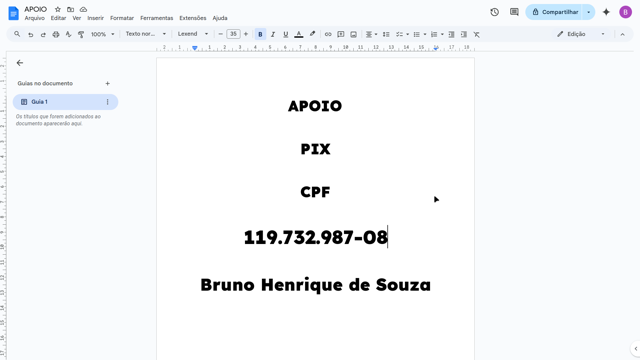

APOIO
PIX
CPF
119.732.987-08
Bruno Henrique de Souza

In [31]:
image_file = 'image_1.png' # @param {type: 'string'}
prompt = "Extraia o texto da imagem" # @param {type: 'string'}


img = resize_image(image_file)
display(img)
response = get_model_response(img, prompt, model, processor)
display(Markdown(response))

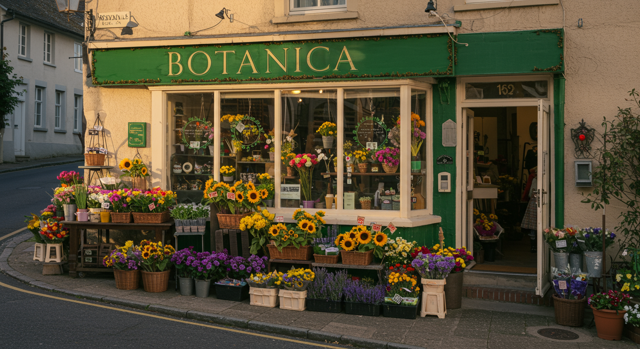

Uma loja de flores.

In [ ]:
image_file = 'image_3.png' # @param {type: 'string'}
prompt = "इस चित्र में क्या है? " # @param {type: 'string'}


img = resize_image(image_file)
display(img)
response = get_model_response(img, prompt, model, processor)
display(Markdown(response))

In [ ]:
!wget https://raw.githubusercontent.com/NSTiwari/Inference-Gemma-3/main/assets/video.mp4 -O /content/video.mp4
!mkdir -p /content/frames

--2025-03-13 23:17:06--  https://raw.githubusercontent.com/NSTiwari/Inference-Gemma-3/main/assets/video.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87026315 (83M) [application/octet-stream]
Saving to: ‘/content/video.mp4’

/content/video.mp4  100%[===================>]  82.99M   441MB/s    in 0.2s    

2025-03-13 23:17:11 (441 MB/s) - ‘/content/video.mp4’ saved [87026315/87026315]



In [ ]:
# Video file.
video_path = "video.mp4" # @param {type : 'string'}

# No. of frames to be extracted from the video.
num_frames = 10 # @param {type : 'integer'}

In [ ]:
video_output = show_video(video_path, video_width=800)
display(video_output)

Buffered data was truncated after reaching the output size limit.

In [ ]:
video_frames = extract_frames(video_path, num_frames=num_frames)

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {
        "role": "user",
        "content": [{"type": "text", "text": "Por favor, resuma o que está acontecendo neste vídeo."}]
    }
]


# Add frames to the messages structure.
for frame_data in video_frames:
    img, timestamp = frame_data
    messages[1]["content"].append({"type": "text", "text": f"Frame at {timestamp} seconds:"})
    img.save(f"/content/frames/frame_{timestamp}.png")
    messages[1]["content"].append({"type": "image", "url": f"/content/frames/frame_{timestamp}.png"})


inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt"
).to(model.device)


input_length = inputs["input_ids"].shape[-1]

# Generate a response based on the inputs.
output = model.generate(**inputs, max_new_tokens=500, do_sample=False)
output = output[0][input_length:]
response = processor.decode(output, skip_special_tokens=True)

display(Markdown(response))